In [1]:
# Recources

# https://www.tensorflow.org/hub
# https://keras.io/api/applications/
# https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2
# https://stackoverflow.com/questions/74367878/is-the-classes-method-of-a-imagedatagenorator-sorted/74411647#74411647

In [2]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tf_keras import layers 

# Use Keras 2.
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

# ***Part 1***

In [9]:
dataset_path = 'C:\\Users\\Karim\\OneDrive\\Documents\\UNI\\SPRING 24\\CMPS 261\\Project\\Food-Item-Recognition\\data'

# Create an ImageDataGenerator for preprocessing images
data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    validation_split=0.2  # Split data into training and validation sets
)

# Load and preprocess training data
train_data_flow = data_generator.flow_from_directory(
    dataset_path,
    target_size=(128, 128),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use training subset
)

# Load and preprocess validation data
val_data_flow = data_generator.flow_from_directory(
    dataset_path,
    target_size=(128, 128),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use validation subset
)

Found 4107 images belonging to 9 classes.
Found 1024 images belonging to 9 classes.


In [4]:
# Read the category file and parse category names and IDs
category_file_path = os.path.join(dataset_path, 'category.txt')
category_mapping = {}
with open(category_file_path, 'r') as f:
    next(f)  # Skip the header line
    for line in f:
        category_id, category_name = line.strip().split('\t')
        category_mapping[int(category_id)] = category_name

In [10]:
# Load the model from TensorFlow Hub
model_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"
hub_layer = hub.KerasLayer(model_url, input_shape=(128, 128, 3) , trainable=False)

# Create a Sequential model
model = keras.Sequential([
    hub_layer,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')])

# Build the Sequential model
model.build((None, 128, 128, 3))

# Summary of the model
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              1692489   
                                                                 
 dense_2 (Dense)             (None, 256)               256512    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 1951314 (7.44 MB)
Trainable params: 258825 (1011.04 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [11]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
# Train the model
history = model.fit(train_data_flow, 
                    validation_data=val_data_flow, 
                    epochs=10)

Epoch 1/10



129/129 [==============================] - 46s 270ms/step - loss: 1.0094 - accuracy: 0.6991 - val_loss: 0.9554 - val_accuracy: 0.7041
Epoch 2/10
129/129 [==============================] - 33s 253ms/step - loss: 0.4912 - accuracy: 0.8369 - val_loss: 0.8795 - val_accuracy: 0.7363
Epoch 3/10
129/129 [==============================] - 33s 253ms/step - loss: 0.3804 - accuracy: 0.8753 - val_loss: 0.9814 - val_accuracy: 0.7188
Epoch 4/10
129/129 [==============================] - 33s 253ms/step - loss: 0.3186 - accuracy: 0.8941 - val_loss: 0.9885 - val_accuracy: 0.7383
Epoch 5/10
129/129 [==============================] - 33s 252ms/step - loss: 0.2555 - accuracy: 0.9128 - val_loss: 1.0497 - val_accuracy: 0.7285
Epoch 6/10
129/129 [==============================] - 32s 251ms/step - loss: 0.2136 - accuracy: 0.9301 - val_loss: 1.0878 - val_accuracy: 0.7139
Epoch 7/10
129/129 [==============================] - 33s 253ms/step - loss: 0.1985 - accuracy: 0.9318 - val_loss: 1.1156 - val_accuracy: 0.7

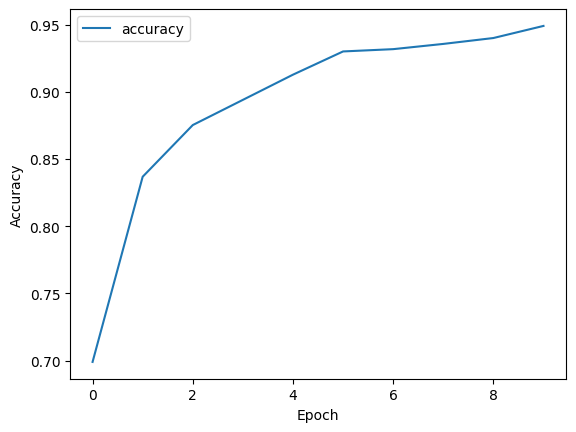

In [13]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import classification_report
import numpy as np

# Initialize empty lists to store predictions and true labels
all_predicted_labels = []
all_true_labels = []

# Iterate over the generator to get predictions batch by batch
for i in range(len(val_data_flow)):
    x_batch, y_batch = val_data_flow[i]
    
    # Generate predictions for the current batch
    batch_predictions = model.predict(x_batch)
    
    # Convert predictions to class labels
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    
    # Convert true labels to class indices if they are one-hot encoded
    if y_batch.shape[1] > 1:
        batch_true_labels = np.argmax(y_batch, axis=1)
    else:
        batch_true_labels = y_batch
    
    # Accumulate batch predictions and true labels
    all_predicted_labels.extend(batch_predicted_labels)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predicted_labels = np.array(all_predicted_labels)
all_true_labels = np.array(all_true_labels)

# Generate classification report
class_names = list(val_data_flow.class_indices.keys())
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))





1/1 [==============================] - 0s 79ms/step
              precision    recall  f1-score   support

           1       0.81      0.95      0.88       330
           2       1.00      1.00      1.00        14
           3       0.51      0.55      0.53       133
           4       0.69      0.82      0.75       102
           5       1.00      0.40      0.57         5
           6       1.00      0.05      0.09        21
           7       0.76      0.71      0.74       133
           8       0.70      0.74      0.72       154
           9       0.69      0.35      0.46       132

    accuracy                           0.73      1024
   macro avg       0.80      0.62      0.64      1024
weighted avg       0.73      0.73      0.71      1024



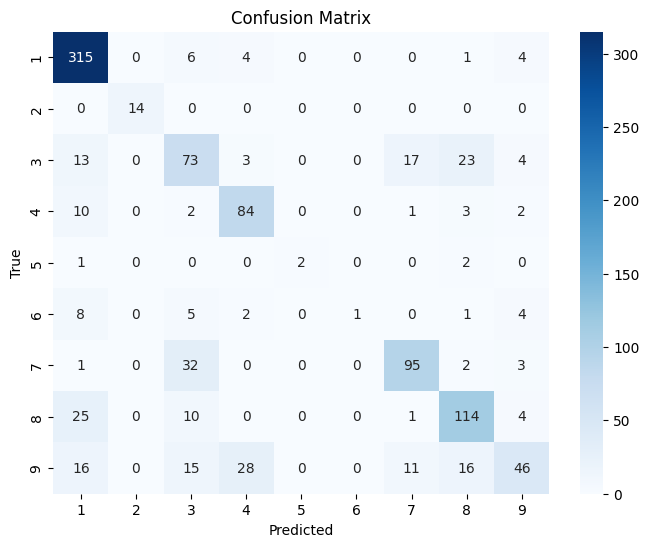

In [19]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# ***PART 2*** (Fixing Overfitting)

Changes made:

1.  Added Data augmentation and  L2 - Regularization as to help reduce overfit
2.  Changed Droput to 0.1 from 0.2
3.  Added epoch callback to get best accuracy

In [22]:
dataset_path = 'C:\\Users\\Karim\\OneDrive\\Documents\\UNI\\SPRING 24\\CMPS 261\\Project\\Food-Item-Recognition\\data'

from tf_keras import regularizers

# Define preprocessing function
def preprocess_image(image):
    # Preprocess input image using ResNet V2 preprocessing function
    return keras.applications.resnet_v2.preprocess_input(image)

# Create an ImageDataGenerator for preprocessing images
data_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_image,
    validation_split=0.2  # Split data into training and validation sets
)

# Augment training data
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_image  # Apply the same preprocessing function for augmentation
)

# Load and preprocess training data with augmentation
train_data_flow = train_data_generator.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load and preprocess validation data
val_data_flow = data_generator.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 5131 images belonging to 9 classes.
Found 1024 images belonging to 9 classes.


In [23]:
from tf_keras import optimizers
# Load the model from TensorFlow Hub
model_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"
hub_layer = hub.KerasLayer(model_url, input_shape=(128, 128, 3) , trainable=False)



# Create a Sequential model with dropout and regularization
model = keras.Sequential([
    hub_layer,
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer= keras.optimizers.Adam(),
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
history = model.fit(train_data_flow, 
                    validation_data=val_data_flow, 
                    epochs=20,
                    )

# Evaluate the model
test_loss, test_acc = model.evaluate(val_data_flow)
print("Test accuracy:", test_acc)

Epoch 1/20
161/161 [==============================] - 60s 341ms/step - loss: 1.7303 - accuracy: 0.5469 - val_loss: 1.3200 - val_accuracy: 0.6660
Epoch 2/20
161/161 [==============================] - 59s 367ms/step - loss: 1.3940 - accuracy: 0.6352 - val_loss: 1.2073 - val_accuracy: 0.6816
Epoch 3/20
161/161 [==============================] - 57s 350ms/step - loss: 1.3028 - accuracy: 0.6597 - val_loss: 1.1075 - val_accuracy: 0.7236
Epoch 4/20
161/161 [==============================] - 55s 340ms/step - loss: 1.2172 - accuracy: 0.6796 - val_loss: 1.0305 - val_accuracy: 0.7646
Epoch 5/20
161/161 [==============================] - 54s 336ms/step - loss: 1.1614 - accuracy: 0.6932 - val_loss: 1.0021 - val_accuracy: 0.7383
Epoch 6/20
161/161 [==============================] - 56s 347ms/step - loss: 1.1314 - accuracy: 0.6991 - val_loss: 0.9796 - val_accuracy: 0.7432
Epoch 7/20
161/161 [==============================] - 57s 357ms/step - loss: 1.0669 - accuracy: 0.7145 - val_loss: 0.8997 - val_ac

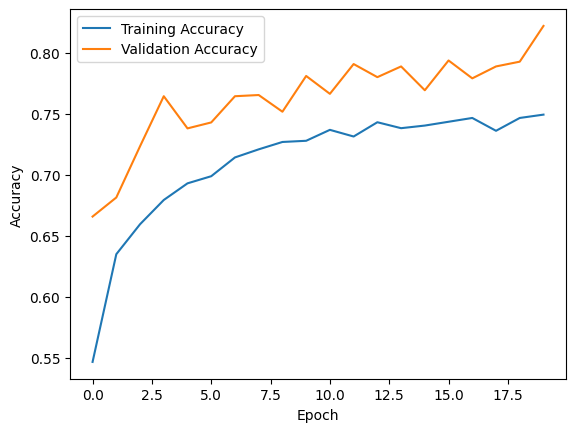

In [24]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [25]:
from sklearn.metrics import classification_report
import numpy as np

# Initialize empty lists to store predictions and true labels
all_predicted_labels = []
all_true_labels = []

# Iterate over the generator to get predictions batch by batch
for i in range(len(val_data_flow)):
    x_batch, y_batch = val_data_flow[i]
    
    # Generate predictions for the current batch
    batch_predictions = model.predict(x_batch)
    
    # Convert predictions to class labels
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    
    # Convert true labels to class indices if they are one-hot encoded
    if y_batch.shape[1] > 1:
        batch_true_labels = np.argmax(y_batch, axis=1)
    else:
        batch_true_labels = y_batch
    
    # Accumulate batch predictions and true labels
    all_predicted_labels.extend(batch_predicted_labels)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predicted_labels = np.array(all_predicted_labels)
all_true_labels = np.array(all_true_labels)

# Generate classification report
class_names = list(val_data_flow.class_indices.keys())
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))


1/1 [==============================] - 0s 92ms/step
              precision    recall  f1-score   support

           1       0.91      0.94      0.92       330
           2       0.87      0.93      0.90        14
           3       0.72      0.59      0.65       133
           4       0.93      0.80      0.86       102
           5       1.00      0.60      0.75         5
           6       0.71      0.48      0.57        21
           7       0.84      0.84      0.84       133
           8       0.79      0.93      0.85       154
           9       0.66      0.69      0.67       132

    accuracy                           0.82      1024
   macro avg       0.82      0.76      0.78      1024
weighted avg       0.82      0.82      0.82      1024



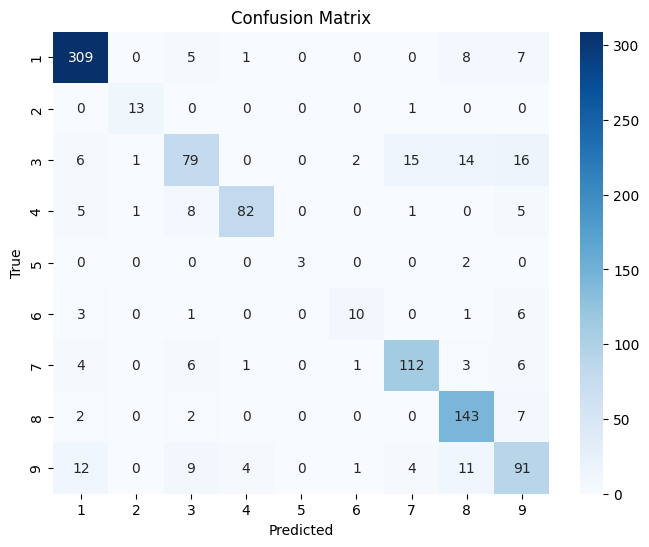

In [26]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# ***PART 3 TRYING TO OBTAIN BEST ACCURACY POSSIBLE***

 Changes made:

1.  Removed data augmentation as accuracy was too low
2.  Changed Droput to 0.1 from 0.2
3.  Added epoch callback to get best accuracy

In [29]:
dataset_path = 'C:\\Users\\Karim\\OneDrive\\Documents\\UNI\\SPRING 24\\CMPS 261\\Project\\Food-Item-Recognition\\data'

from tf_keras import regularizers

# Define preprocessing function
def preprocess_image(image):
    # Preprocess input image using ResNet V2 preprocessing function
    return keras.applications.resnet_v2.preprocess_input(image)

# Create an ImageDataGenerator for preprocessing images
data_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_image,
    validation_split=0.2  # Split data into training and validation sets
)

# Augment training data
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_image  # Apply the same preprocessing function for augmentation
)

# Load and preprocess training data with augmentation
train_data_flow = train_data_generator.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load and preprocess validation data
val_data_flow = data_generator.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 5131 images belonging to 9 classes.
Found 1024 images belonging to 9 classes.


In [33]:
from tf_keras import optimizers
# Load the model from TensorFlow Hub
model_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"
hub_layer = hub.KerasLayer(model_url, input_shape=(128, 128, 3) , trainable=False)



# Create a Sequential model with dropout and regularization
model = keras.Sequential([
    hub_layer,
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.1),
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer= keras.optimizers.Adam(),
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
history = model.fit(train_data_flow, 
                    validation_data=val_data_flow,
                    callbacks = early_stopping, 
                    epochs=30,
                    )

# Evaluate the model
test_loss, test_acc = model.evaluate(val_data_flow)
print("Test accuracy:", test_acc)

Epoch 1/30
161/161 [==============================] - 63s 312ms/step - loss: 1.5185 - accuracy: 0.6408 - val_loss: 1.1469 - val_accuracy: 0.7324
Epoch 2/30
161/161 [==============================] - 49s 304ms/step - loss: 1.0650 - accuracy: 0.7597 - val_loss: 1.0047 - val_accuracy: 0.7734
Epoch 3/30
161/161 [==============================] - 48s 299ms/step - loss: 0.8983 - accuracy: 0.8006 - val_loss: 0.8364 - val_accuracy: 0.8174
Epoch 4/30
161/161 [==============================] - 46s 289ms/step - loss: 0.7983 - accuracy: 0.8355 - val_loss: 0.7254 - val_accuracy: 0.8516
Epoch 5/30
161/161 [==============================] - 47s 291ms/step - loss: 0.7171 - accuracy: 0.8585 - val_loss: 0.6426 - val_accuracy: 0.8779
Epoch 6/30
161/161 [==============================] - 47s 294ms/step - loss: 0.6492 - accuracy: 0.8753 - val_loss: 0.5979 - val_accuracy: 0.8965
Epoch 7/30
161/161 [==============================] - 44s 271ms/step - loss: 0.6024 - accuracy: 0.8835 - val_loss: 0.5654 - val_ac

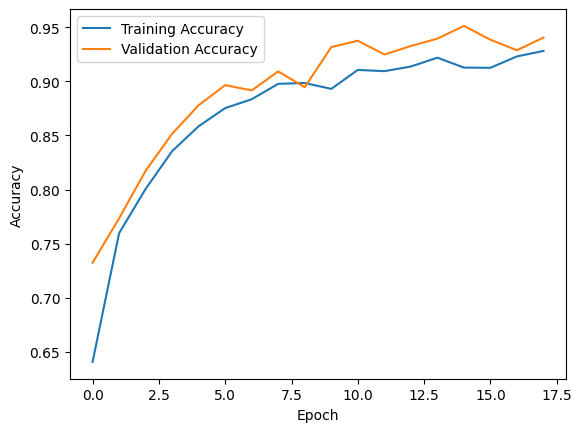

In [34]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import classification_report
import numpy as np

# Initialize empty lists to store predictions and true labels
all_predicted_labels = []
all_true_labels = []

# Iterate over the generator to get predictions batch by batch
for i in range(len(val_data_flow)):
    x_batch, y_batch = val_data_flow[i]
    
    # Generate predictions for the current batch
    batch_predictions = model.predict(x_batch)
    
    # Convert predictions to class labels
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    
    # Convert true labels to class indices if they are one-hot encoded
    if y_batch.shape[1] > 1:
        batch_true_labels = np.argmax(y_batch, axis=1)
    else:
        batch_true_labels = y_batch
    
    # Accumulate batch predictions and true labels
    all_predicted_labels.extend(batch_predicted_labels)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predicted_labels = np.array(all_predicted_labels)
all_true_labels = np.array(all_true_labels)

# Generate classification report
class_names = list(val_data_flow.class_indices.keys())
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

1/1 [==============================] - 0s 104ms/step
              precision    recall  f1-score   support

           1       0.99      0.95      0.97       330
           2       1.00      0.93      0.96        14
           3       0.80      0.96      0.87       133
           4       0.94      0.96      0.95       102
           5       1.00      1.00      1.00         5
           6       1.00      0.81      0.89        21
           7       0.96      0.98      0.97       133
           8       0.98      0.92      0.95       154
           9       0.90      0.89      0.89       132

    accuracy                           0.94      1024
   macro avg       0.95      0.93      0.94      1024
weighted avg       0.95      0.94      0.94      1024



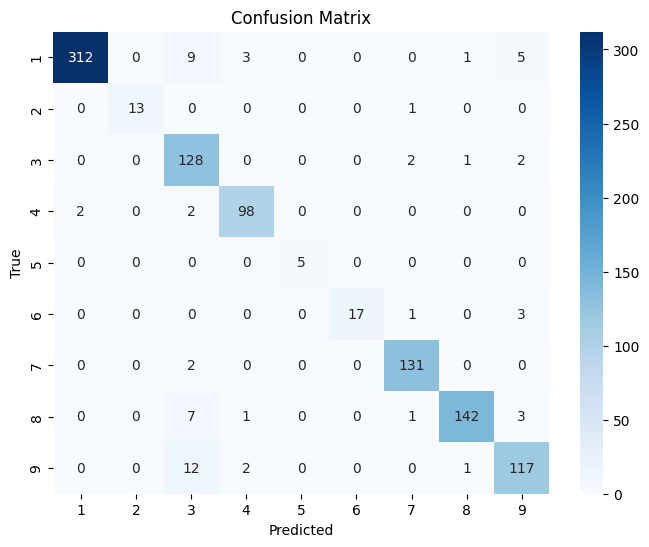

In [36]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [37]:
# Assuming 'model' is your trained model
# Define the file name for the exported model
file_name = "exported_model"

# Get the current directory
current_directory = os.getcwd()

# Construct the file path
file_path = os.path.join(current_directory, file_name)

# Export the model to the file path
model.export(file_path)


INFO:tensorflow:Assets written to: Trained_Model\assets


INFO:tensorflow:Assets written to: Trained_Model\assets
